In [ ]:
import numpy as np  # linear algebra
import pandas as pd  #
from datetime import datetime, date, timedelta
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV,Ridge,Lasso,ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor,RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.svm import SVR, LinearSVC
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import time
from itertools import product
import datetime as dt
import calendar
import gc

RANDOM_SEED = 42
# 引入中文字体
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname="/home/aistudio/NotoSansCJKsc-Light.otf", size=12)

In [ ]:
import pandas as pd 
pd.Series([1,2,3],index=['a','b','c'])

a    1
b    2
c    3
dtype: int64

In [ ]:
PATH = './data/data19383/'
train = pd.read_csv(PATH + 'train.csv')
# train = pd.read_csv('./data/data19383/train.csv', usecols=[2, 3, 4, 6, 7, 18])
# set index to ID to avoid droping it later
# 把测试集的id列作为索引，防止误删
test  = pd.read_csv(PATH + 'submission.csv').set_index('customer_id')

In [ ]:
# 对于特别大的文件，我们需要做一些内存检查
mem_train = train.memory_usage(index=True).sum()
mem_test=test.memory_usage(index=True).sum()
print(u"训练集使用内容 "+ str(mem_train/ 1024**2)+" MB")
print(u"测试集使用内存 "+ str(mem_test/ 1024**2)+" MB")

训练集使用内容 510.40091705322266 MB
测试集使用内存 24.200225830078125 MB


In [ ]:
train.head()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,...,customer_gender,member_status,is_member_actived,goods_id,goods_class_id,goods_price,goods_status,goods_has_discount,goods_list_time,goods_delist_time
0,1000000,1000000,1.0,239.9,96.9,0.0,2012-11-01 00:10:56,6,1.0,0.0,...,NaN,NaN,NaN,998,998,54.909289,1.0,0.0,2014-10-25 11:08:07,2014-11-01 11:08:07
1,1001530,1001327,2.0,288.0,96.9,0.0,2013-08-31 23:14:42,6,2.0,0.0,...,NaN,NaN,NaN,1953,1953,45.961352,0.0,1.0,2013-08-28 17:27:50,2013-09-01 00:38:17
2,1001531,1001327,2.0,288.0,96.9,0.0,2013-08-31 23:14:42,6,2.0,0.0,...,NaN,NaN,NaN,1083,1083,53.035439,1.0,0.0,2014-10-29 18:21:05,2014-11-05 18:21:05
3,1001532,1001328,3.0,180.0,89.7,0.0,2013-08-31 22:06:35,6,1.0,0.0,...,NaN,NaN,NaN,1013,1013,46.046917,1.0,1.0,2014-10-25 11:00:00,2014-11-01 11:00:00
4,1001533,1001329,1.0,159.9,65.9,0.0,2013-08-31 21:33:36,6,1.0,0.0,...,NaN,NaN,NaN,1628,1628,50.722161,1.0,0.0,2014-10-23 15:35:33,2014-10-30 15:35:33


### 训练集文件
- order_detail_id	订单详情id
- order_id	订单id
- order_total_num	订单商品总购买数量
- order_amount	订单商品总金额
- order_total_payment	订单实付金额
- order_total_discount	订单优惠金额
- order_pay_time	付款时间
- order_status	订单状态： 1表示等待买家付款， 2表示卖家部分发货， 3表示卖家发货， 4表示等待买家确认收货， 5表示买家已签收， 6表示交易成功
- order_count	订单包含的子订单数量
- is_customer_rate	用户是否评价，0没有评价，1已经评价
- order_detail_status	订单详细状态
- order_detail_goods_num	订单中的商品数量
- order_detail_amount	订单应付总金额
- order_detail_payment	订单实付金额
- order_detail_discount	订单优惠金额
- member_id	会员id
- customer_id	用户id
- customer_gender	性别：0未知，1男，2女
- customer_province	用户省份所在地
- customer_city	用户城市所在地
- member_status	会员状态：1正常，2冻结，3已删除
- is_member_actived	会员是否激活：0没有激活，1已激活
- goods_id	商品id
- goods_class_id	商品分类id
- goods_price	商品原始价格
- goods_status	商品库存状态：1出售中，2库中
- goods_has_discount	是否支持会员折扣：0不支持，1支持
- goods_list_time	商品最新上架时间
- goods_delist_time	商品最新下架时间

### 提交文件
- customer_id	用户id
- result	下个月是否会购买：0 不购买，1购买


In [ ]:
def summary_stats_table(data):
    '''
    a function to summerize all types of data
    分类型按列的数据分布与异常值统计
    '''
    # count of nulls
    # 空值数量
    missing_counts = pd.DataFrame(data.isnull().sum())
    missing_counts.columns = ['count_null']

    # numeric column stats
    # 数值列数据分布统计
    num_stats = data.select_dtypes(include=['int64','float64']).describe().loc[['count','min','max','25%','50%','75%']].transpose()
    num_stats['dtype'] = data.select_dtypes(include=['int64','float64']).dtypes.tolist()

    # non-numeric value stats
    # 非数值列数据分布统计
    non_num_stats = data.select_dtypes(exclude=['int64','float64']).describe().transpose()
    non_num_stats['dtype'] = data.select_dtypes(exclude=['int64','float64']).dtypes.tolist()
    non_num_stats = non_num_stats.rename(columns={"first": "min", "last": "max"})

    # merge all 
    # 聚合结果
    stats_merge = pd.concat([num_stats, non_num_stats], axis=0, join='outer', ignore_index=False, keys=None,
              levels=None, names=None, verify_integrity=False, copy=True, sort=False).fillna("").sort_values('dtype')

    column_order = ['dtype', 'count', 'count_null','unique','min','max','25%','50%','75%','top','freq']
    summary_stats = pd.merge(stats_merge, missing_counts, left_index=True, right_index=True, sort=False)[column_order]
    return(summary_stats)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2306871 entries, 0 to 2306870
Data columns (total 29 columns):
order_detail_id           int64
order_id                  int64
order_total_num           float64
order_amount              float64
order_total_payment       float64
order_total_discount      float64
order_pay_time            object
order_status              int64
order_count               float64
is_customer_rate          float64
order_detail_status       float64
order_detail_goods_num    float64
order_detail_amount       float64
order_detail_payment      float64
order_detail_discount     float64
customer_province         object
customer_city             object
member_id                 float64
customer_id               int64
customer_gender           float64
member_status             float64
is_member_actived         float64
goods_id                  int64
goods_class_id            int64
goods_price               float64
goods_status              float64
goods_has_discount

从下面的基本信息分析表中可以看出：
- 商品原始价格`goods_price`出现了负数而订单优惠折扣`order_detail_discount`出现了正数的情况，需要进一步分析
- 双十一的影响在订单细节上反映也非常明显
- 订单状态`order_status`最大值101，不在赛题说明中，但是有98145条记录，怀疑交易失败等异常情况。

In [ ]:
summary_stats_table(train)

,dtype,count,count_null,unique,min,max,25%,50%,75%,top,freq
order_detail_id,int64,2306871.0,0,,1e+06,3.6855e+06,1.66968e+06,2.33935e+06,3.00743e+06,,
order_id,int64,2306871.0,0,,1e+06,3.23836e+06,1.57148e+06,2.14299e+06,2.70795e+06,,
goods_class_id,int64,2306871.0,0,,998,6673,1038,1233,1643,,
order_status,int64,2306871.0,0,,0,101,6,6,6,,
goods_id,int64,2306871.0,0,,998,6673,1038,1233,1643,,
customer_id,int64,2306871.0,0,,1e+06,2.82657e+06,1.43643e+06,1.92957e+06,2.45782e+06,,
goods_has_discount,float64,2306871.0,0,,0,1,0,0,0,,
goods_status,float64,2306871.0,0,,0,2,1,1,1,,
goods_price,float64,2306435.0,436,,-79.9748,92.3526,49.6004,53.9093,54.8506,,
is_member_actived,float64,635790.0,1671081,,1,1,1,1,1,,


In [ ]:
train[train.order_status>6].head()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,...,customer_gender,member_status,is_member_actived,goods_id,goods_class_id,goods_price,goods_status,goods_has_discount,goods_list_time,goods_delist_time
18,1001547,1001340,2.0,339.8,89.9,0.0,2013-08-31 15:13:04,101,2.0,0.0,...,NaN,NaN,NaN,998,998,54.836807,1.0,0.0,2014-10-25 11:08:07,2014-11-01 11:08:07
19,1001548,1001340,2.0,339.8,89.9,0.0,2013-08-31 15:13:04,101,2.0,0.0,...,NaN,NaN,NaN,1958,1958,46.118263,2.0,0.0,2013-09-21 08:58:00,2013-09-27 17:37:59
20,1001549,1001341,1.0,239.9,89.9,0.0,2013-08-31 15:00:04,101,1.0,0.0,...,NaN,NaN,NaN,998,998,54.810267,1.0,0.0,2014-10-25 11:08:07,2014-11-01 11:08:07
73,1001602,1001374,2.0,298.9,39.9,0.0,2013-08-30 10:08:38,101,2.0,0.0,...,NaN,NaN,NaN,1983,1983,53.037544,1.0,1.0,2014-10-28 14:31:17,2014-11-04 14:31:17
74,1001603,1001374,2.0,298.9,39.9,0.0,2013-08-30 10:08:38,101,2.0,0.0,...,NaN,NaN,NaN,1468,1468,46.181811,0.0,1.0,2014-04-18 11:00:22,2014-04-18 17:00:38


训练集有2306871条数据，占用的内存会比较大，可以对内存进行一定的优化。

可以考虑的优化步骤包括
- 查询列的数值范围
- 给每一列选择合适的数值类型
- 修改数值类型
- 把日期列切成年月日3列(默认的datatime会比较占空间)
- 填充NaN

In [ ]:
# 处理id字段
train['order_detail_id'] = train['order_detail_id'].astype(np.uint32)
train['order_id'] = train['order_id'].astype(np.uint32)
train['customer_id'] = train['customer_id'].astype(np.uint32)
train['goods_id'] = train['goods_id'].astype(np.uint32)
train['goods_class_id'] = train['goods_class_id'].astype(np.uint32)
train['member_id'] = train['member_id'].astype(np.uint32)
# 处理状态字段，这里同时处理空值，将空值置为0
train['order_status'] = train['order_status'].astype(np.uint8)
train['goods_has_discount'] = train['goods_has_discount'].astype(np.uint8)
train["is_member_actived"].fillna(0, inplace=True)
train["is_member_actived"]=train["is_member_actived"].astype(np.int8)
train["member_status"].fillna(0, inplace=True)
train["member_status"]=train["member_status"].astype(np.int8)
train["customer_gender"].fillna(0, inplace=True)
train["customer_gender"]=train["customer_gender"].astype(np.int8)
train['is_customer_rate'] = train['is_customer_rate'].astype(np.uint8)
train['order_detail_status'] = train['order_detail_status'].astype(np.uint8)
# 处理日期
train['goods_list_time']=pd.to_datetime(train['goods_list_time'],format="%Y-%m-%d")
train['order_pay_time']=pd.to_datetime(train['order_pay_time'],format="%Y-%m-%d")
train['goods_delist_time']=pd.to_datetime(train['goods_delist_time'],format="%Y-%m-%d")
# 检查内存使用
mem_train = train.memory_usage(index=True).sum()
mem_test=test.memory_usage(index=True).sum()
print(u"训练集使用内容 "+ str(mem_train/ 1024**2)+" MB")
print(u"测试集使用内存 "+ str(mem_test/ 1024**2)+" MB")

训练集使用内容 349.8006525039673 MB
测试集使用内存 24.200225830078125 MB


### 商品原始价格分析
- 从图中可以看出负值价格的商品情况还是比较多的，但这里有个非常奇怪的情况，这些负值商品涉及的订单并没有折扣标记。难道是买二送一？或者优惠券？
- 进一步分析发现，这些负值价格的商品流水记录尽管有2145条，对应只有25个商品`id`，集中度非常高
	- 有可能是默认的赠品？
    - 也可能是类似“一元/分钱抢XXX”活动的商品
    - 还有可能是活动商品
  
 这里引发了一个怀疑，商品价格是不是真的商品价格？有电商购物经验时我们会知道，有时优惠券抵扣的价格会以比较奇怪的形式（可能是按比例）分摊在每个商品上，如果是这样的话，那么这里商品价格的特征要附加是否有优惠券抵扣？不清楚业务规则的情况下，商品价格的特征处理比较麻烦。

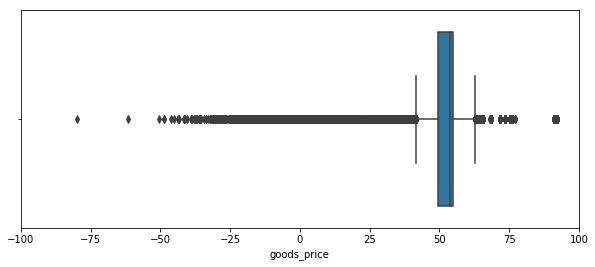

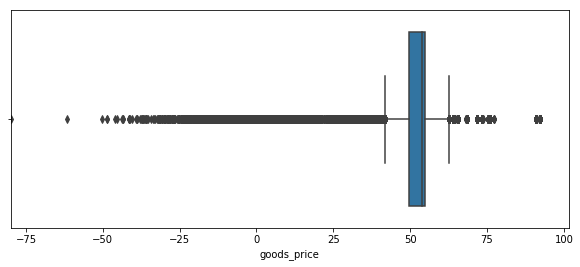

In [ ]:
plt.figure(figsize=(10,4))
# x轴坐标范围
plt.xlim(-100, 100)
sns.boxplot(x=train.goods_price)

plt.figure(figsize=(10,4))
# x轴坐标范围
plt.xlim(train.goods_price.min(), train.goods_price.max()*1.1)
sns.boxplot(x=train.goods_price)

In [ ]:
train[train.goods_price<0].head()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,...,customer_gender,member_status,is_member_actived,goods_id,goods_class_id,goods_price,goods_status,goods_has_discount,goods_list_time,goods_delist_time
2312,1003841,1003239,1.0,0.01,0.01,0.0,2013-05-12 20:21:07,6,1.0,0,...,0,0,0,2538,2538,-12.965136,1.0,0,2014-10-28 09:43:51,2014-11-04 09:43:51
2523,1004052,1003440,1.0,0.01,0.01,0.0,2013-04-22 10:22:39,6,1.0,0,...,0,0,0,2538,2538,-9.717323,1.0,0,2014-10-28 09:43:51,2014-11-04 09:43:51
2822,1004351,1003720,23.0,23.00,23.00,0.0,2013-04-03 21:40:50,6,1.0,0,...,0,0,0,1768,1768,-0.334533,1.0,0,2014-10-28 11:30:18,2014-11-04 11:30:18
5203,1006732,1005821,1.0,1.00,1.00,0.0,2013-01-24 22:00:31,6,1.0,0,...,0,0,0,3098,3098,-16.420158,2.0,0,2014-01-10 15:47:52,2014-01-11 12:46:23
6193,1007722,1006556,1.0,1.00,1.00,0.0,2013-01-09 14:13:06,6,1.0,0,...,0,0,0,3278,3278,-7.076659,2.0,0,2013-01-09 14:00:00,2013-01-09 14:00:06


### 订单优惠折扣分析
这块数据就更奇怪了，感觉`goods_has_discount`这个字段反映的根本不是折扣的真实情况，诸如类似一元抢购和绝大多数折扣的场景根本没有识别出来

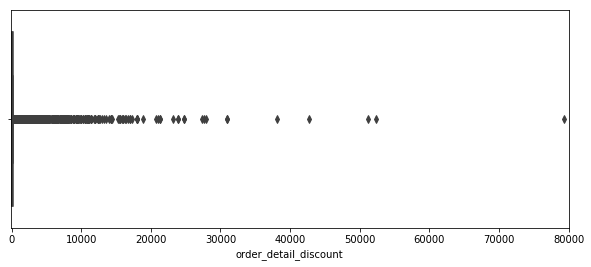

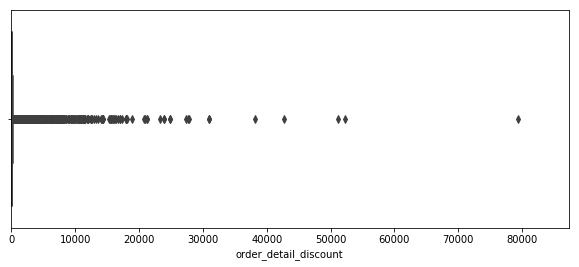

In [ ]:
plt.figure(figsize=(10,4))
# x轴坐标范围
plt.xlim(-120, 80000)
sns.boxplot(x=train.order_detail_discount)

plt.figure(figsize=(10,4))
# x轴坐标范围
plt.xlim(train.order_detail_discount.min(), train.order_detail_discount.max()*1.1)
sns.boxplot(x=train.order_detail_discount)

In [ ]:
train[train.order_detail_discount>70000].head()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,...,customer_gender,member_status,is_member_actived,goods_id,goods_class_id,goods_price,goods_status,goods_has_discount,goods_list_time,goods_delist_time
1376878,2598479,2364075,256.0,102374.0,22984.4,30.0,2013-01-25 15:26:09,3,1.0,0,...,0,0,0,4473,4473,59.945033,2.0,0,2013-02-19 11:57:38,2013-02-24 10:47:56


In [ ]:
train[train.order_detail_discount<0].head()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,...,customer_gender,member_status,is_member_actived,goods_id,goods_class_id,goods_price,goods_status,goods_has_discount,goods_list_time,goods_delist_time
9313,1010842,1009334,2.0,545.8,465.8,50.0,2012-11-11 08:24:57,6,1.0,0,...,0,0,0,3733,3733,63.994268,2.0,0,2012-11-06 15:53:21,2012-11-11 01:41:31
9328,1010857,1009349,1.0,120.5,85.5,25.0,2012-11-11 09:15:22,6,1.0,0,...,0,0,0,3008,3008,55.232862,1.0,0,2014-10-24 16:30:39,2014-10-31 16:30:39
9346,1010875,1009367,1.0,120.5,85.5,25.0,2012-11-11 01:01:09,6,1.0,0,...,0,0,0,3008,3008,55.243978,1.0,0,2014-10-24 16:30:39,2014-10-31 16:30:39
9362,1010891,1009383,1.0,120.5,85.5,25.0,2012-11-11 01:02:18,6,1.0,0,...,0,0,0,3008,3008,55.197161,1.0,0,2014-10-24 16:30:39,2014-10-31 16:30:39
9365,1010894,1009386,1.0,116.4,86.4,20.0,2012-11-11 01:03:33,6,1.0,0,...,0,0,0,1858,1858,56.777319,1.0,0,2014-10-24 23:59:59,2014-10-31 23:59:59


## 中文id映射
有一些字段是中文，在服务器上不好显示，这里先做ID映射

但其实这样处理省市信息还是有点问题的，后续应该要改，比赛数据集的id列都需要额外处理

> 在机器学习算法中，特征之间距离的计算是十分重要的。因此，直接把离散变量的取值转化为数值，并不能很好地代表特征之间的距离——《深入理解XGBoost：高效机器学习算法与进阶》

In [ ]:
train['customer_city_id'] = LabelEncoder().fit_transform(train['customer_city'].astype(str))
train['customer_province_id'] = LabelEncoder().fit_transform(train['customer_province'].astype(str))

## 日期处理
- 下单日期就以付款时间为准
- 商品的上架和下架时间比较难处理，但是还是需要
    - 如果商品下架，预测销量应该直接为0才对

In [ ]:
# 处理日期
# train['order_pay_time']=pd.to_datetime(train['order_pay_time'],format="%Y-%m-%d")
# 增加年月日时间字段
train['Year'] = pd.DatetimeIndex(train['order_pay_time']).year
train['Month'] = pd.DatetimeIndex(train['order_pay_time']).month
train['Day'] =pd.DatetimeIndex(train['order_pay_time']).day.astype(np.uint8)
train['Hour'] =pd.DatetimeIndex(train['order_pay_time']).hour

年度销售情况

In [ ]:
# 切分不同的时间段
train_2012=train.loc[train['Year']==2012]
train_2013=train.loc[train['Year'] ==2013]

# EDA
## 探索用户分布基本信息

### 用户性别

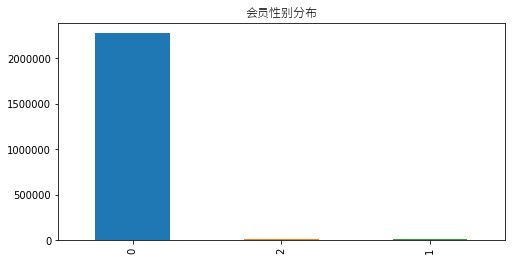

In [ ]:
# 用户性别基本未知，这个标签基本没法用
plt.figure(figsize=(8,4))
plt.title('会员性别分布', fontproperties=myfont)
train.customer_gender.value_counts().plot.bar()

### 用户城市

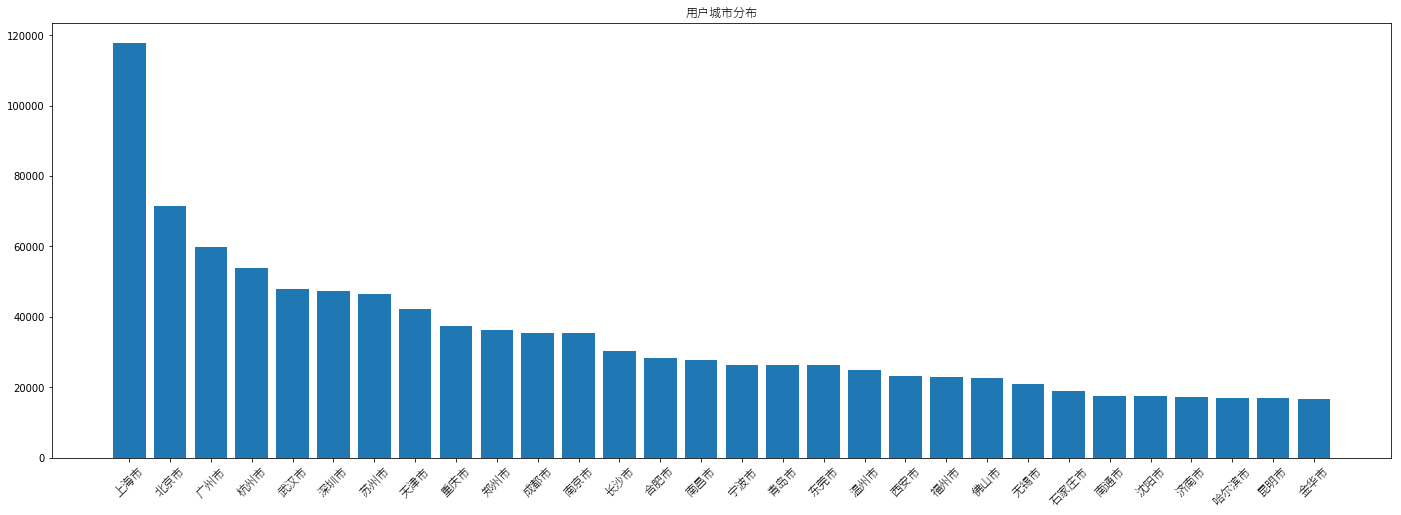

In [ ]:
plt.figure(figsize=(24,8))
plt.title('用户城市分布',fontproperties=myfont)
x = train.customer_city.value_counts().head(30).index
# train.customer_city.value_counts().head(30).plot.bar()
plt.bar(train.customer_city.value_counts().head(30).index, train.customer_city.value_counts().head(30).values)
# 做坐标刻度
plt.xticks(x, fontproperties=myfont, rotation=45)
plt.show()

### 用户省份

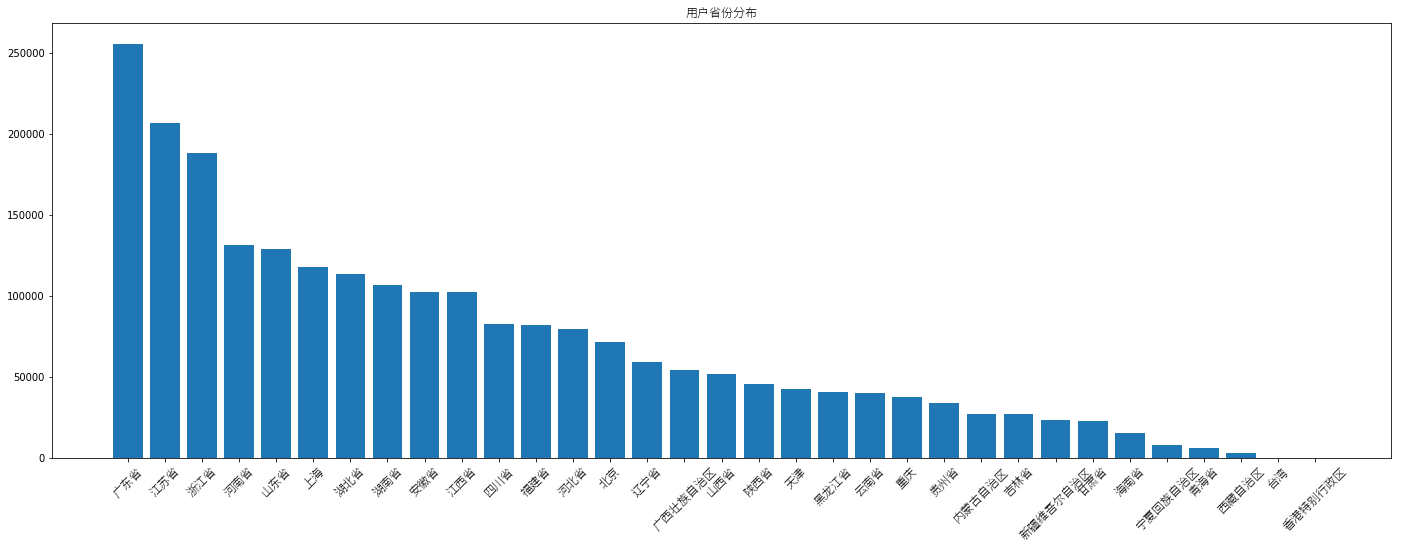

In [ ]:
plt.figure(figsize=(24,8))
plt.title('用户省份分布',fontproperties=myfont)
x = train.customer_province.value_counts().index
plt.bar(train.customer_province.value_counts().index, train.customer_province.value_counts().values)
# 做坐标刻度
plt.xticks(x, fontproperties=myfont, rotation=45)
plt.show()

### 会员状态

(array([0, 1]), <a list of 2 Text xticklabel objects>)

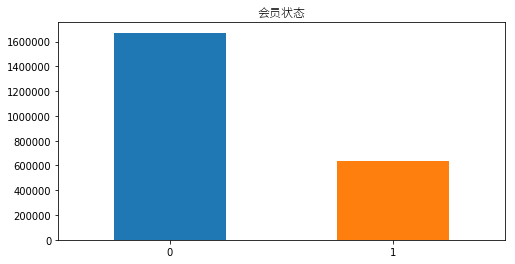

In [ ]:
plt.figure(figsize=(8,4))
plt.title('会员状态',fontproperties=myfont)
train.member_status.value_counts().plot.bar()
plt.xticks(rotation=0)

### 是否会员

(array([0, 1]), <a list of 2 Text xticklabel objects>)

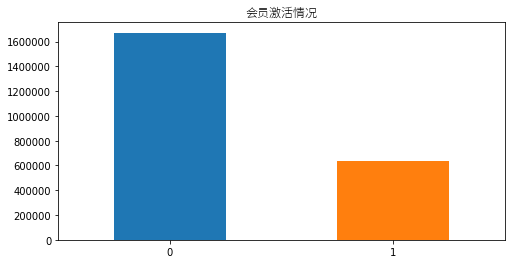

In [ ]:
plt.figure(figsize=(8,4))
plt.title('会员激活情况',fontproperties=myfont)
train.is_member_actived.value_counts().plot.bar()
plt.xticks(rotation=0)

### 用户id分布

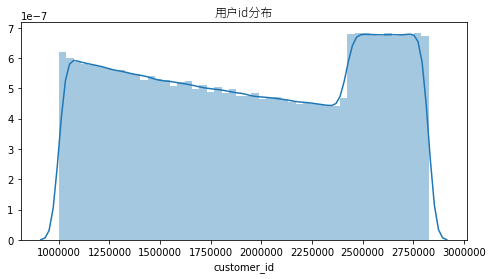

In [ ]:
plt.figure(figsize=(8,4))
plt.title('用户id分布',fontproperties=myfont)
sns.distplot(train.customer_id)

### 用户行为

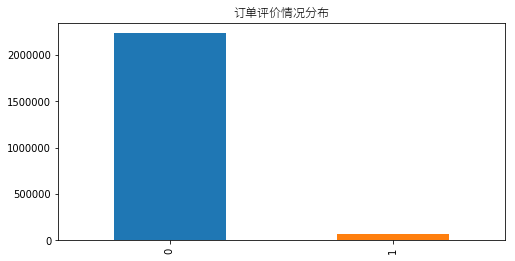

In [ ]:
plt.figure(figsize=(8,4))
plt.title('订单评价情况分布', fontproperties=myfont)
train.is_customer_rate.value_counts().plot.bar()

## 探索商品分布基本信息

### 商品分布

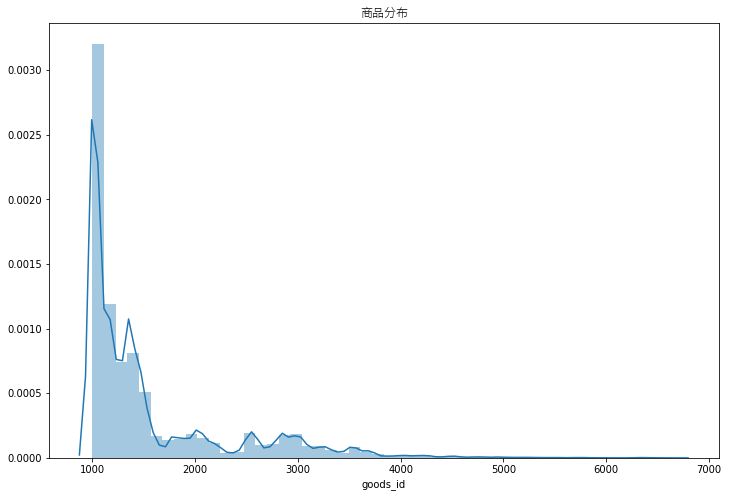

In [ ]:
plt.figure(figsize=(12,8))
plt.title('商品分布', fontproperties=myfont)
sns.distplot(train.goods_id)

### 商品类别
其实看下面两张图就会发现，这个数据集中，没有真正的商品类别，`train.goods_class_id`就是`train.goods_id`，后续可能需要用聚类算法对商品进行分类

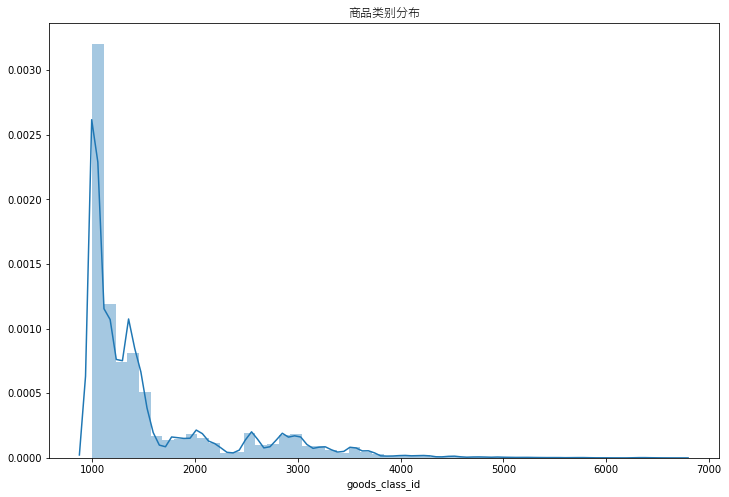

In [ ]:
plt.figure(figsize=(12,8))
plt.title('商品类别分布', FontProperties=myfont)
sns.distplot(train.goods_class_id)

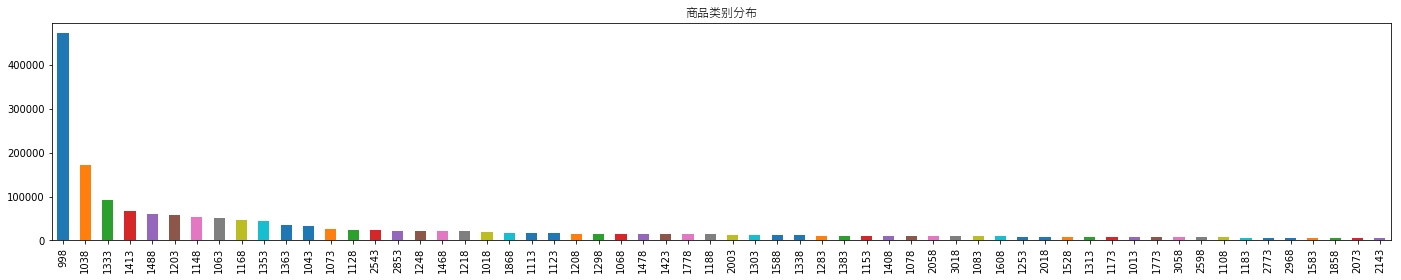

In [ ]:
plt.figure(figsize=(24,4))
plt.title('商品类别分布', FontProperties=myfont)
train.goods_class_id.value_counts().head(60).plot.bar()

### 是否会员优惠

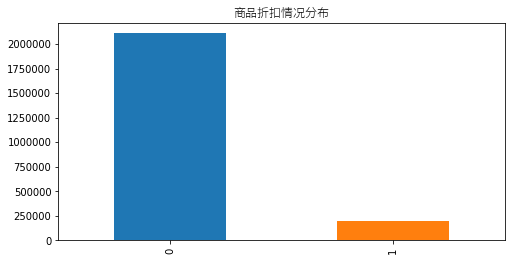

In [ ]:
plt.figure(figsize=(8,4))
plt.title('商品折扣情况分布', FontProperties=myfont)
train.goods_has_discount.value_counts().plot.bar()

### 商品价格

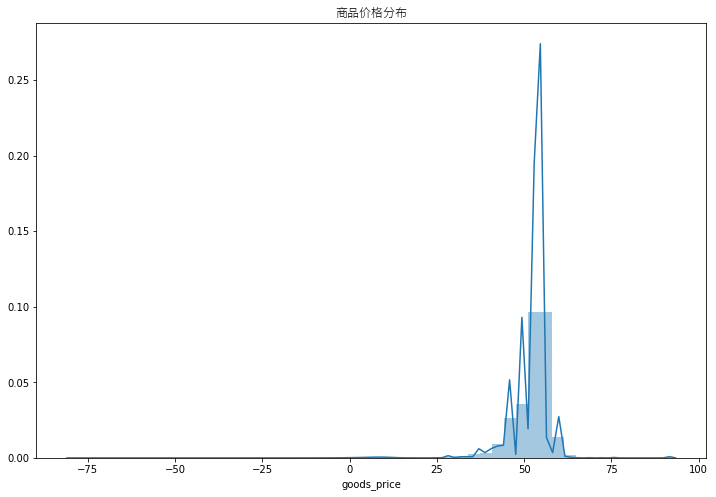

In [ ]:
plt.figure(figsize=(12,8))
plt.title('商品价格分布', FontProperties=myfont)
sns.distplot(train.goods_price)

## 探索异常交易数据分布
全数据集中有9万多条`order_status`为101的数据，怀疑是交易失败、撤单数据，即使2月1日之后也有8万多条，这些数据是否要纳入考虑？这部分比较纠结，因为从用户的角度说，如果已经到了下单了以后才撤单，很可能是确实比较想买；但也无法排除恶意刷单的问题。

In [ ]:
tmp = train[train.order_status==101][train.order_pay_time>'2013-02-01']
tmp.head()

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,...,goods_status,goods_has_discount,goods_list_time,goods_delist_time,customer_city_id,customer_province_id,Year,Month,Day,Hour
18,1001547,1001340,2.0,339.8,89.9,0.0,2013-08-31 15:13:04,101,2.0,0,...,1.0,0,2014-10-25 11:08:07,2014-11-01 11:08:07,90,6,2013,8,31,15
19,1001548,1001340,2.0,339.8,89.9,0.0,2013-08-31 15:13:04,101,2.0,0,...,2.0,0,2013-09-21 08:58:00,2013-09-27 17:37:59,90,6,2013,8,31,15
20,1001549,1001341,1.0,239.9,89.9,0.0,2013-08-31 15:00:04,101,1.0,0,...,1.0,0,2014-10-25 11:08:07,2014-11-01 11:08:07,157,17,2013,8,31,15
73,1001602,1001374,2.0,298.9,39.9,0.0,2013-08-30 10:08:38,101,2.0,0,...,1.0,1,2014-10-28 14:31:17,2014-11-04 14:31:17,100,8,2013,8,30,10
74,1001603,1001374,2.0,298.9,39.9,0.0,2013-08-30 10:08:38,101,2.0,0,...,0.0,1,2014-04-18 11:00:22,2014-04-18 17:00:38,100,8,2013,8,30,10


In [ ]:
tmp.describe()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_status,order_count,is_customer_rate,order_detail_status,...,goods_class_id,goods_price,goods_status,goods_has_discount,customer_city_id,customer_province_id,Year,Month,Day,Hour
count,8.069000e+04,8.069000e+04,80690.000000,80690.000000,80690.000000,80690.000000,80690.0,80690.000000,80690.0,80690.0,...,80690.000000,80681.000000,80690.000000,80690.000000,80690.000000,80690.000000,80690.0,80690.000000,80690.000000,80690.000000
mean,2.367592e+06,2.159158e+06,1.628727,295.842292,113.194452,2.369286,101.0,1.311166,0.0,101.0,...,1429.857541,52.599164,1.041058,0.123919,178.180803,15.996815,2013.0,5.117871,13.701400,12.962684
std,7.791512e+05,6.540363e+05,3.540653,380.475620,155.684910,10.017603,0.0,0.758133,0.0,0.0,...,640.106176,5.780158,0.379437,0.329491,106.804837,7.494300,0.0,2.344358,8.942865,5.809662
min,1.001547e+06,1.001340e+06,1.000000,0.010000,0.010000,0.000000,101.0,1.000000,0.0,101.0,...,998.000000,-26.782614,0.000000,0.000000,0.000000,0.000000,2013.0,2.000000,1.000000,0.000000
25%,1.689368e+06,1.588600e+06,1.000000,199.000000,66.900000,0.000000,101.0,1.000000,0.0,101.0,...,1018.000000,50.917234,1.000000,0.000000,80.000000,11.000000,2013.0,3.000000,6.000000,10.000000
50%,2.373472e+06,2.172060e+06,1.000000,239.900000,89.900000,0.000000,101.0,1.000000,0.0,101.0,...,1168.000000,53.956080,1.000000,0.000000,185.000000,16.000000,2013.0,5.000000,13.000000,12.000000
75%,3.049230e+06,2.740576e+06,2.000000,299.700000,109.900000,0.000000,101.0,1.000000,0.0,101.0,...,1488.000000,54.853561,1.000000,0.000000,273.000000,20.000000,2013.0,8.000000,21.000000,17.000000
max,3.685470e+06,3.238344e+06,479.000000,23990.000000,10035.000000,600.000000,101.0,16.000000,0.0,101.0,...,6563.000000,92.352598,2.000000,1.000000,375.000000,33.000000,2013.0,8.000000,31.000000,23.000000


### 会员状态

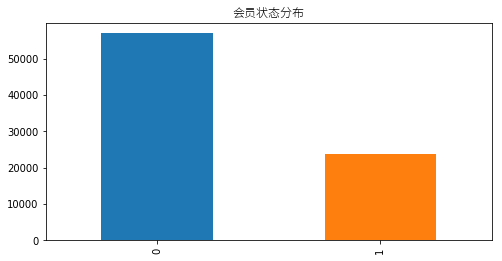

In [ ]:
plt.figure(figsize=(8,4))
plt.title('会员状态分布', fontproperties=myfont)
tmp.member_status.value_counts().plot.bar()

### 交易金额

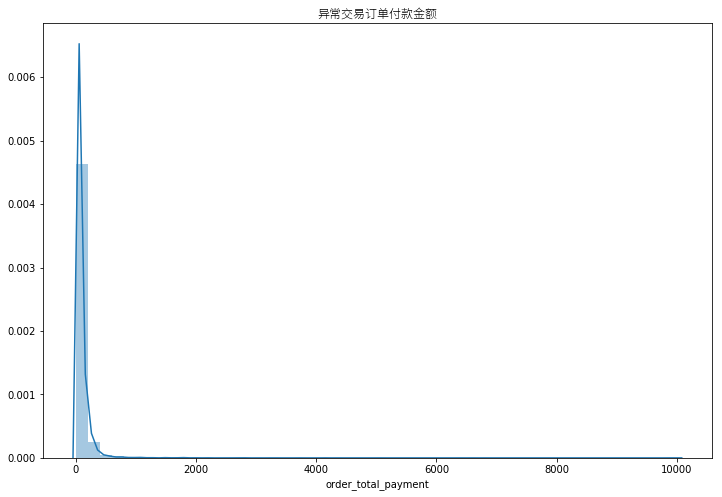

In [ ]:
plt.figure(figsize=(12,8))
plt.title('异常交易订单付款金额', fontproperties=myfont)
sns.distplot(tmp.order_total_payment)

### 商品分布

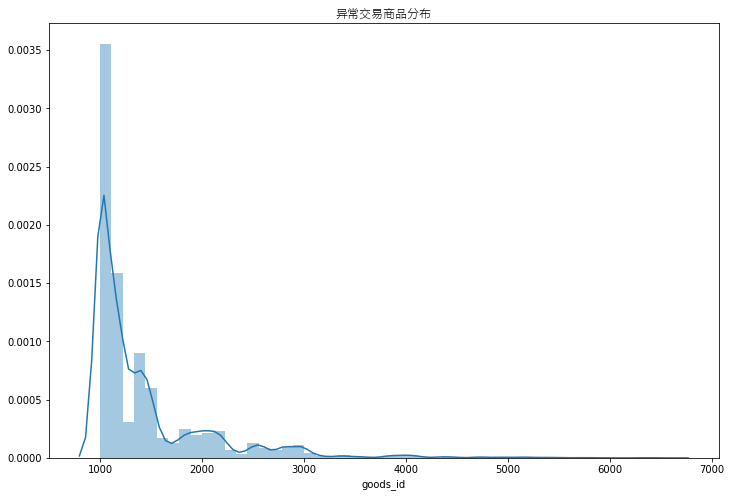

In [ ]:
plt.figure(figsize=(12,8))
plt.title('异常交易商品分布', fontproperties=myfont)
sns.distplot(tmp.goods_id)

### 用户分布

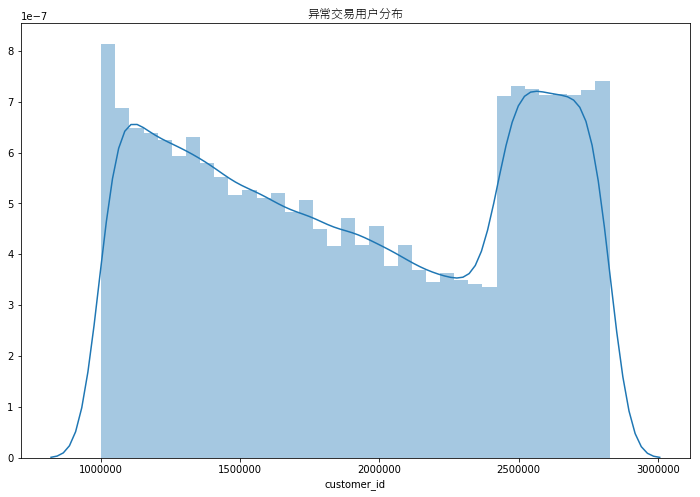

In [ ]:
plt.figure(figsize=(12,8))
plt.title('异常交易用户分布', fontproperties=myfont)
sns.distplot(tmp.customer_id)

### 城市分布

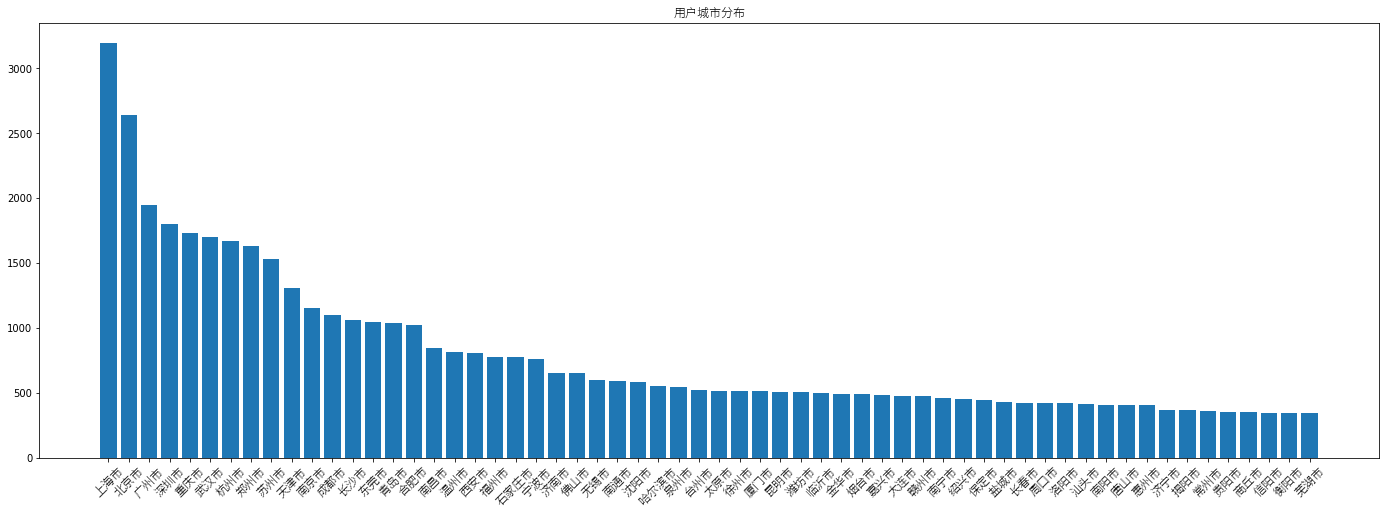

In [ ]:
plt.figure(figsize=(24,8))
plt.title('用户城市分布',fontproperties=myfont)
x = tmp.customer_city.value_counts().head(60).index
plt.bar(tmp.customer_city.value_counts().head(60).index, tmp.customer_city.value_counts().head(60).values)
# 做坐标刻度
plt.xticks(x, fontproperties=myfont, rotation=45)
plt.show()

### 省份分布

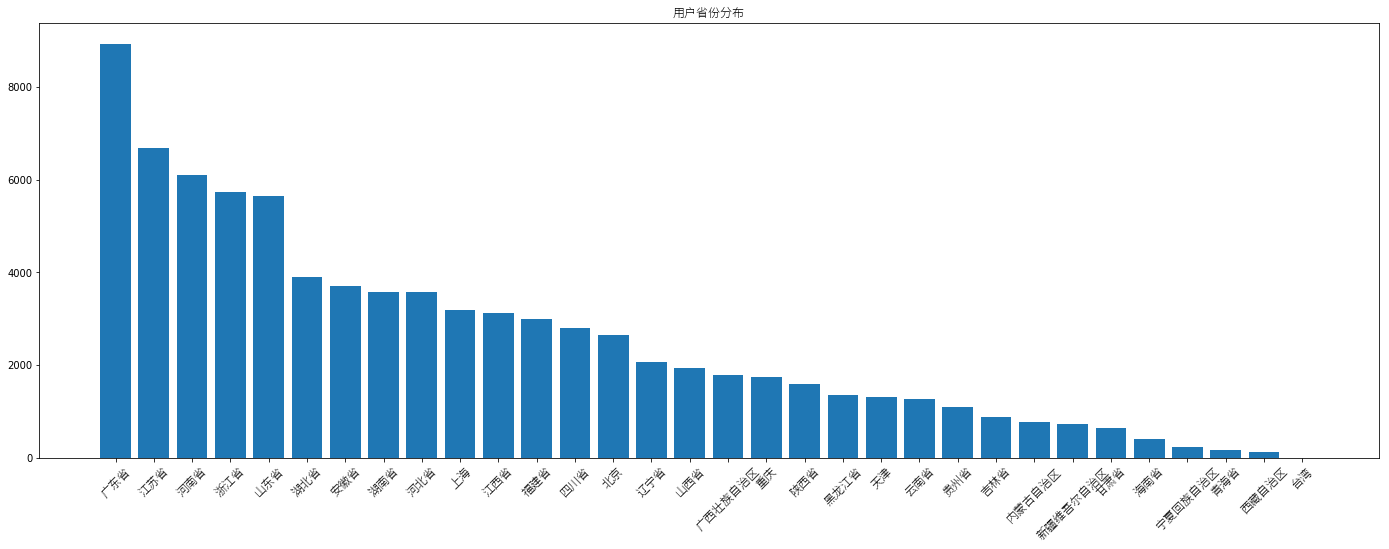

In [ ]:
plt.figure(figsize=(24,8))
plt.title('用户省份分布',fontproperties=myfont)
x = tmp.customer_province.value_counts().index
# train.customer_city.value_counts().head(30).plot.bar()
plt.bar(tmp.customer_province.value_counts().index, tmp.customer_province.value_counts().values)
# 做坐标刻度
plt.xticks(x, fontproperties=myfont, rotation=45)
plt.show()

### 商品类别分布

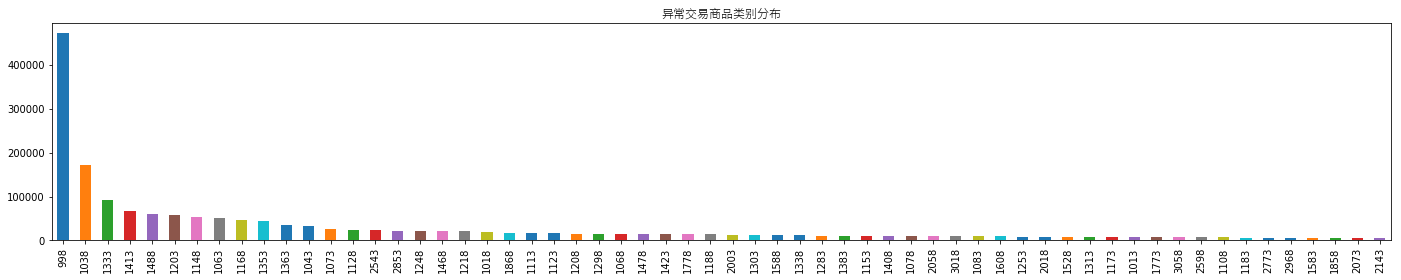

In [ ]:
plt.figure(figsize=(24,4))
plt.title('异常交易商品类别分布', FontProperties=myfont)
train.goods_class_id.value_counts().head(60).plot.bar()

### 商品价格分布

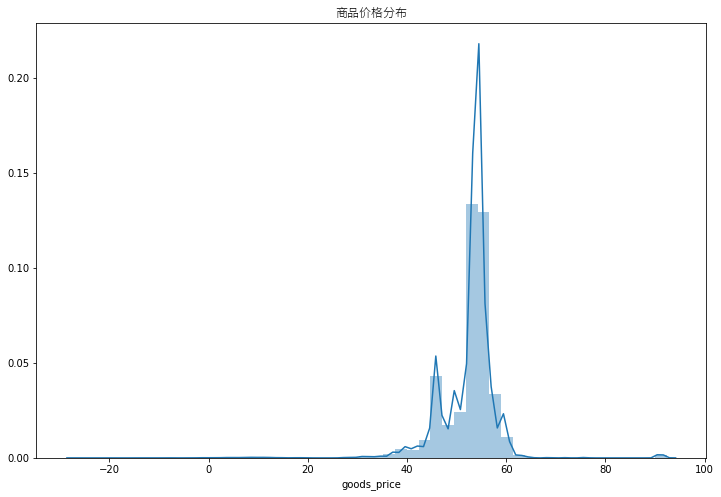

In [ ]:
plt.figure(figsize=(12,8))
plt.title('商品价格分布', FontProperties=myfont)
sns.distplot(tmp.goods_price)

### 折扣分布

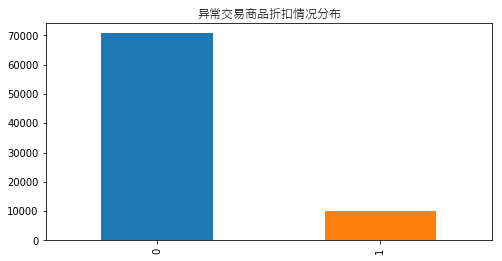

In [ ]:
plt.figure(figsize=(8,4))
plt.title('异常交易商品折扣情况分布', FontProperties=myfont)
tmp.goods_has_discount.value_counts().plot.bar()

In [ ]:
# 训练集全部用户数量
len(train['customer_id'].unique())

1585986

In [ ]:
# 将用户下单金额按天进行汇总
df = train[train.order_pay_time>'2013-02-01']
df['date'] = pd.DatetimeIndex(df['order_pay_time']).date
df_payment = df[['customer_id','date','order_total_payment']]

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
len(df_payment['customer_id'].unique())

685471

In [ ]:
df_payment = df_payment.groupby(['date','customer_id']).agg({'order_total_payment': ['sum']})
df_payment.columns = ['day_total_payment']
df_payment.reset_index(inplace=True)

In [ ]:
df_payment = df_payment.set_index(
    ["customer_id", "date"])[["day_total_payment"]].unstack(level=-1).fillna(0)# unstack(level=-1) 该操作会将行中数据透视到列,level: 默认为-1，即行索引的最后一级
df_payment.columns = df_payment.columns.get_level_values(1)# get_level_values(1)# 行索引有多个，索引第2个的值

In [ ]:
df_goods = df[['customer_id','date','order_total_num']]
df_goods = df_goods.groupby(['date','customer_id']).agg({'order_total_num': ['sum']})
df_goods.columns = ['day_total_num']
df_goods.reset_index(inplace=True)
df_goods = df_goods.set_index(
    ["customer_id", "date"])[["day_total_num"]].unstack(level=-1).fillna(0)
df_goods.columns = df_goods.columns.get_level_values(1)

In [ ]:
# 这是一个时间滑窗函数，获得dt之前minus天以来periods的dataframe，以便进一步计算
def get_timespan(df, dt, minus, periods, freq='D'):
    # get_timespan(df_payment, date(2013, 6, 6), 7, 7) 就是从df_payment中取出从20130606往前7天的日期范围的数据也就是20130530-20130605
    print('timedelta(days=minus)',timedelta(days=minus))
    print('dt',dt)
    # print('pd.date_range(dt - timedelta(days=minus)',pd.date_range(dt - timedelta(days=minus),periods=periods, freq=freq))
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

In [ ]:
# @from: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65/code
# @liscense: Apache 2.0
# @author: weijian
def reduce_mem_usage(props):
    # 计算当前内存
    start_mem_usg = props.memory_usage().sum() / 1024 ** 2
    print("Memory usage of the dataframe is :", start_mem_usg, "MB")
    
    # 哪些列包含空值，空值用-999填充。why：因为np.nan当做float处理
    NAlist = []
    for col in props.columns:
        # 这里只过滤了objectd格式，如果你的代码中还包含其他类型，请一并过滤
        if (props[col].dtypes != object):
            
            # print("**************************")
            # print("columns: ", col)
            # print("dtype before", props[col].dtype)
            
            # 判断是否是int类型
            isInt = False
            mmax = props[col].max()
            mmin = props[col].min()
            
            # Integer does not support NA, therefore Na needs to be filled
            if not np.isfinite(props[col]).all():
                NAlist.append(col)
                props[col].fillna(-999, inplace=True) # 用-999填充
                
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = np.fabs(props[col] - asint)
            result = result.sum()
            if result < 0.01: # 绝对误差和小于0.01认为可以转换的，要根据task修改
                isInt = True
            
            # make interger / unsigned Integer datatypes
            if isInt:
                if mmin >= 0: # 最小值大于0，转换成无符号整型
                    if mmax <= 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mmax <= 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mmax <= 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else: # 转换成有符号整型
                    if mmin > np.iinfo(np.int8).min and mmax < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mmin > np.iinfo(np.int16).min and mmax < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mmin > np.iinfo(np.int32).min and mmax < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mmin > np.iinfo(np.int64).min and mmax < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)  
            else: # 注意：这里对于float都转换成float16，需要根据你的情况自己更改
                props[col] = props[col].astype(np.float16)
            
            # print("dtype after", props[col].dtype)
            # print("********************************")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [ ]:
def prepare_dataset(df_payment, df_goods, dt, is_train=True):
    X = {}
    # 整合用户id
    tmp = df_payment.reset_index()
    X['customer_id'] = tmp['customer_id']
    del tmp
    gc.collect()
    # 消费特征
    print('Preparing payment feature...')
    for i in [7,14,30,49,60,91,120]:
        tmp_1 = get_timespan(df_payment, dt, i, i)
        X['mean_%s' % i] = tmp_1.mean(axis=1).values
        X['median_%s' % i] = tmp_1.median(axis=1).values
        X['max_%s' % i] = tmp_1.max(axis=1).values
        X['sum_%s' % i] = tmp_1.sum(axis=1).values
        # 最近i天内销售额
        X['has_sales_days_in_last_%s' % i] = (tmp_1 != 0).sum(axis=1).values
        # 最后i天内有销售
        X['last_has_sales_day_in_last_%s' % i] = i - ((tmp_1 != 0) * np.arange(i)).max(axis=1).values
        # 第一个销售日在最后一个i天内
        X['first_has_sales_day_in_last_%s' % i] = ((tmp_1 != 0) * np.arange(i, 0, -1)).max(axis=1).values
        del tmp_1
        # 取dt日期往前推一周的i天前的数据
        tmp_2 = get_timespan(df_payment, dt + timedelta(weeks=-1), i, i)
        X['mean_%s_2' % i] = tmp_2.mean(axis=1).values
        X['median_%s_2' % i] = tmp_2.median(axis=1).values
        X['max_%s_2' % i] = tmp_2.max(axis=1).values
        del tmp_2
        gc.collect()

    # 对此处进行微调，主要考虑近期因素
    for i in range(1, 4):
        X['day_%s_2018' % i] = get_timespan(df_payment, dt, i*30, 30).sum(axis=1).values

    for i in range(7):
        X['mean_4_dow{}_2013'.format(i)] = get_timespan(df_payment, dt, 56-i*2, 4, freq='14D').mean(axis=1).values
        # X['mean_20_dow{}_2013'.format(i)] = get_timespan(df, dt, 140-i, 20, freq='7D').mean(axis=1).values
        X['mean_20_dow{}_2013'.format(i)] = get_timespan(df_payment, dt, 140-i*2, 10, freq='14D').mean(axis=1).values
    
    # 商品数量特征，这里故意把时间和消费特征错开，提高时间滑窗的覆盖面
    print('Preparing num feature...')
    for i in [3,21,35,49,70,84,105]:
            tmp_1 = get_timespan(df_goods, dt, i, i)
            X['goods_mean_%s' % i] = tmp_1.mean(axis=1).values
            X['goods_median_%s' % i] = tmp_1.median(axis=1).values
            X['goods_max_%s' % i] = tmp_1.max(axis=1).values
            X['goods_sum_%s' % i] = tmp_1.sum(axis=1).values
            # 在过去i天内有多少商品销售
            X['goods_has_sales_days_in_last_%s' % i] = (tmp_1 > 0).sum(axis=1).values
            # 货物在最后i天有销售的天数
            X['goods_last_has_sales_day_in_last_%s' % i] = i - ((tmp_1 > 0) * np.arange(i)).max(axis=1).values
            # 货物在前i天有销售的天数
            X['goods_first_has_sales_day_in_last_%s' % i] = ((tmp_1 > 0) * np.arange(i, 0, -1)).max(axis=1).values
            # 取dt日期往前推一周的i天前的数据
            del tmp_1
            tmp_2 = get_timespan(df_goods, dt + timedelta(weeks=-1), i, i)
            X['goods_mean_%s_2' % i] = tmp_2.mean(axis=1).values
            X['goods_median_%s_2' % i] = tmp_2.median(axis=1).values
            X['goods_max_%s_2' % i] = tmp_2.max(axis=1).values
            X['goods_sum_%s_2' % i] = tmp_2.sum(axis=1).values
            del tmp_2
            gc.collect()
    # 对此处进行微调，主要考虑近期因素
    for i in range(1, 4):
        X['goods_day_%s_2018' % i] = get_timespan(df_goods, dt, i*28, 28).sum(axis=1).values

    for i in range(7):
        X['goods_mean_4_dow{}_2013'.format(i)] = get_timespan(df_goods, dt, 56-i*2, 4, freq='14D').mean(axis=1).values
        # X['mean_20_dow{}_2013'.format(i)] = get_timespan(df, dt, 140-i, 20, freq='7D').mean(axis=1).values
        X['goods_mean_20_dow{}_2013'.format(i)] = get_timespan(df_goods, dt, 140-i*2, 10, freq='14D').mean(axis=1).values

    X = pd.DataFrame(X)
    
    reduce_mem_usage(X)
    
    if is_train:
        # 这样转换之后，打标签直接用numpy切片就可以了
        # 当然这里前提是确认付款总额没有负数的问题
        y = df_goods[pd.date_range(dt, periods=30)].max(axis=1).values
        y[y > 0] = 1
        return X, y
    return X

In [ ]:
def make_slides(train,df_part,begin,end,column):
    # 将用户下单金额按天进行汇总
    df = train[(train.order_pay_time > begin)&(train.order_pay_time < end)]
    df = pd.merge(df,df_part,how='inner')
    df['date'] = pd.DatetimeIndex(df['order_pay_time']).date
    df = df[['customer_id', 'date', column]]
    df = df.groupby(['date', 'customer_id']).agg({column: ['sum']})
    df.columns = ['day_' + column]
    df.reset_index(inplace=True)
    df = df.set_index(
        ["customer_id", "date"])[['day_' + column]].unstack(level=-1).fillna(0)
    df.columns = df.columns.get_level_values(1)
    return df

In [ ]:
# part1 2013.06.06之前的用户，在2013.06.06后30天的时间滑窗
df_0606 = train[(train.order_pay_time > '2013-01-01')&(train.order_pay_time <= '2013-06-06')][['customer_id']]
df_0606 = df_0606.drop_duplicates(['customer_id'])
df_part1_partment = make_slides(train,df_0606,'2013-01-01','2013-07-06','order_total_payment')
df_part1_goods = make_slides(train,df_0606,'2013-01-01','2013-07-06','order_total_num')
X_part1, y_part1 = prepare_dataset(df_part1_partment, df_part1_goods, date(2013, 6, 6))

Preparing payment feature...
timedelta(days=minus) 7 days, 0:00:00
dt 2013-06-06
timedelta(days=minus) 7 days, 0:00:00
dt 2013-05-30
timedelta(days=minus) 14 days, 0:00:00
dt 2013-06-06
timedelta(days=minus) 14 days, 0:00:00
dt 2013-05-30
timedelta(days=minus) 30 days, 0:00:00
dt 2013-06-06
timedelta(days=minus) 30 days, 0:00:00
dt 2013-05-30
timedelta(days=minus) 49 days, 0:00:00
dt 2013-06-06
timedelta(days=minus) 49 days, 0:00:00
dt 2013-05-30
timedelta(days=minus) 60 days, 0:00:00
dt 2013-06-06
timedelta(days=minus) 60 days, 0:00:00
dt 2013-05-30
timedelta(days=minus) 91 days, 0:00:00
dt 2013-06-06
timedelta(days=minus) 91 days, 0:00:00
dt 2013-05-30
timedelta(days=minus) 120 days, 0:00:00
dt 2013-06-06
timedelta(days=minus) 120 days, 0:00:00
dt 2013-05-30
timedelta(days=minus) 30 days, 0:00:00
dt 2013-06-06
timedelta(days=minus) 60 days, 0:00:00
dt 2013-06-06
timedelta(days=minus) 90 days, 0:00:00
dt 2013-06-06
timedelta(days=minus) 56 days, 0:00:00
dt 2013-06-06
timedelta(days=mi

In [ ]:
X_part1.to_pickle('./X_part1.pkl')
np.save("./y_part1.npy", y_part1)

In [ ]:
# 清理内存
del df_0606
del df_part1_partment
del df_part1_goods
del X_part1
del y_part1
gc.collect()

48

In [ ]:
# part2 2013.06.20之前的用户，在2013.06.20后30天的时间滑窗
df_0620 = train[(train.order_pay_time > '2013-01-15')&(train.order_pay_time <= '2013-06-20')][['customer_id']]
df_0620 = df_0620.drop_duplicates(['customer_id'])
df_part2_partment = make_slides(train,df_0620,'2013-01-15','2013-07-20','order_total_payment')
df_part2_goods = make_slides(train,df_0620,'2013-01-15','2013-07-20','order_total_num')
X_part2, y_part2 = prepare_dataset(df_part2_partment, df_part2_goods, date(2013, 6, 20))

Preparing payment feature...
timedelta(days=minus) 7 days, 0:00:00
dt 2013-06-20
timedelta(days=minus) 7 days, 0:00:00
dt 2013-06-13
timedelta(days=minus) 14 days, 0:00:00
dt 2013-06-20
timedelta(days=minus) 14 days, 0:00:00
dt 2013-06-13
timedelta(days=minus) 30 days, 0:00:00
dt 2013-06-20
timedelta(days=minus) 30 days, 0:00:00
dt 2013-06-13
timedelta(days=minus) 49 days, 0:00:00
dt 2013-06-20
timedelta(days=minus) 49 days, 0:00:00
dt 2013-06-13
timedelta(days=minus) 60 days, 0:00:00
dt 2013-06-20
timedelta(days=minus) 60 days, 0:00:00
dt 2013-06-13
timedelta(days=minus) 91 days, 0:00:00
dt 2013-06-20
timedelta(days=minus) 91 days, 0:00:00
dt 2013-06-13
timedelta(days=minus) 120 days, 0:00:00
dt 2013-06-20
timedelta(days=minus) 120 days, 0:00:00
dt 2013-06-13
timedelta(days=minus) 30 days, 0:00:00
dt 2013-06-20
timedelta(days=minus) 60 days, 0:00:00
dt 2013-06-20
timedelta(days=minus) 90 days, 0:00:00
dt 2013-06-20
timedelta(days=minus) 56 days, 0:00:00
dt 2013-06-20
timedelta(days=mi

In [ ]:
X_part2.to_pickle('./X_part2.pkl')
np.save("./y_part2.npy", y_part2)

In [ ]:
%%time
del df_0620
del df_part2_partment
del df_part2_goods
del X_part2
del y_part2
gc.collect()

CPU times: user 112 ms, sys: 148 ms, total: 260 ms
Wall time: 262 ms


In [ ]:
%%time
# part3 2013.07.01之前的用户，在2013.07.01后30天的时间滑窗
df_0701 = train[(train.order_pay_time > '2013-01-26')&(train.order_pay_time <= '2013-07-01')][['customer_id']]
df_0701 = df_0701.drop_duplicates(['customer_id'])
df_part3_partment = make_slides(train,df_0701,'2013-01-26','2013-07-31','order_total_payment')
df_part3_goods = make_slides(train,df_0701,'2013-01-26','2013-07-31','order_total_num')
X_part3, y_part3 = prepare_dataset(df_part3_partment, df_part3_goods, date(2013, 7, 1))

Preparing payment feature...
timedelta(days=minus) 7 days, 0:00:00
dt 2013-07-01
timedelta(days=minus) 7 days, 0:00:00
dt 2013-06-24
timedelta(days=minus) 14 days, 0:00:00
dt 2013-07-01
timedelta(days=minus) 14 days, 0:00:00
dt 2013-06-24
timedelta(days=minus) 30 days, 0:00:00
dt 2013-07-01
timedelta(days=minus) 30 days, 0:00:00
dt 2013-06-24
timedelta(days=minus) 49 days, 0:00:00
dt 2013-07-01
timedelta(days=minus) 49 days, 0:00:00
dt 2013-06-24
timedelta(days=minus) 60 days, 0:00:00
dt 2013-07-01
timedelta(days=minus) 60 days, 0:00:00
dt 2013-06-24
timedelta(days=minus) 91 days, 0:00:00
dt 2013-07-01
timedelta(days=minus) 91 days, 0:00:00
dt 2013-06-24
timedelta(days=minus) 120 days, 0:00:00
dt 2013-07-01
timedelta(days=minus) 120 days, 0:00:00
dt 2013-06-24
timedelta(days=minus) 30 days, 0:00:00
dt 2013-07-01
timedelta(days=minus) 60 days, 0:00:00
dt 2013-07-01
timedelta(days=minus) 90 days, 0:00:00
dt 2013-07-01
timedelta(days=minus) 56 days, 0:00:00
dt 2013-07-01
timedelta(days=mi

In [ ]:
X_part3.to_pickle('./X_part3.pkl')
np.save("./y_part3.npy", y_part3)

In [ ]:
del df_0701
del df_part3_partment
del df_part3_goods
del X_part3
del y_part3
gc.collect()

86

In [ ]:
%%time
# part4 2013.07.15之前的用户，在2013.07.15后30天的时间滑窗
df_0715 = train[(train.order_pay_time > '2013-02-10')&(train.order_pay_time <= '2013-07-15')][['customer_id']]
df_0715 = df_0715.drop_duplicates(['customer_id'])
df_part4_partment = make_slides(train,df_0715,'2013-02-10','2013-08-16','order_total_payment')
df_part4_goods = make_slides(train,df_0715,'2013-02-10','2013-08-16','order_total_num')
X_part4, y_part4 = prepare_dataset(df_part4_partment, df_part4_goods, date(2013, 7, 15))

Preparing payment feature...
timedelta(days=minus) 7 days, 0:00:00
dt 2013-07-15
timedelta(days=minus) 7 days, 0:00:00
dt 2013-07-08
timedelta(days=minus) 14 days, 0:00:00
dt 2013-07-15
timedelta(days=minus) 14 days, 0:00:00
dt 2013-07-08
timedelta(days=minus) 30 days, 0:00:00
dt 2013-07-15
timedelta(days=minus) 30 days, 0:00:00
dt 2013-07-08
timedelta(days=minus) 49 days, 0:00:00
dt 2013-07-15
timedelta(days=minus) 49 days, 0:00:00
dt 2013-07-08
timedelta(days=minus) 60 days, 0:00:00
dt 2013-07-15
timedelta(days=minus) 60 days, 0:00:00
dt 2013-07-08
timedelta(days=minus) 91 days, 0:00:00
dt 2013-07-15
timedelta(days=minus) 91 days, 0:00:00
dt 2013-07-08
timedelta(days=minus) 120 days, 0:00:00
dt 2013-07-15
timedelta(days=minus) 120 days, 0:00:00
dt 2013-07-08
timedelta(days=minus) 30 days, 0:00:00
dt 2013-07-15
timedelta(days=minus) 60 days, 0:00:00
dt 2013-07-15
timedelta(days=minus) 90 days, 0:00:00
dt 2013-07-15
timedelta(days=minus) 56 days, 0:00:00
dt 2013-07-15
timedelta(days=mi

In [ ]:
%%time
X_part4.to_pickle('./X_part4.pkl')
np.save("./y_part4.npy", y_part4)

CPU times: user 96 ms, sys: 236 ms, total: 332 ms
Wall time: 335 ms


In [ ]:
%%time
del df_0715
del df_part4_partment
del df_part4_goods
del X_part4
del y_part4
gc.collect()

CPU times: user 104 ms, sys: 68 ms, total: 172 ms
Wall time: 171 ms


In [ ]:
%%time
# 将四部分训练集整合
print("Preparing Train dataset...")
X_l, y_l = [], []
X_part1 = pd.read_pickle('./X_part1.pkl')
y_part1 = np.load('./y_part1.npy')
X_l.append(X_part1)
y_l.append(y_part1)
X_part2 = pd.read_pickle('./X_part2.pkl')
y_part2 = np.load('./y_part2.npy')
X_l.append(X_part2)
y_l.append(y_part2)
X_part3 = pd.read_pickle('./X_part3.pkl')
y_part3 = np.load('./y_part3.npy')
X_l.append(X_part3)
y_l.append(y_part3)
X_part4 = pd.read_pickle('./X_part4.pkl')
y_part4 = np.load('./y_part4.npy')
X_l.append(X_part4)
y_l.append(y_part4)
X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
print('done!')
del X_l
del y_l
del X_part1
del y_part1
del X_part2
del y_part2
del X_part3
del y_part3
del X_part4
del y_part4
gc.collect()
X_train.to_pickle('./X_train.pkl')
np.save("./y_train.npy", y_train)

Preparing Train dataset...
done!
CPU times: user 2.39 s, sys: 3.15 s, total: 5.54 s
Wall time: 5.67 s


In [ ]:
%%time
# 2013.08.01之前的用户，在2013.08.01后30天的时间滑窗
print("Preparing Validation dataset...")
df_0801 = train[(train.order_pay_time > '2013-03-01')&(train.order_pay_time <= '2013-08-01')][['customer_id']]
df_0801 = df_0801.drop_duplicates(['customer_id'])
df_part5_partment = make_slides(train,df_0801,'2013-03-01','2013-08-31','order_total_payment')
df_part5_goods = make_slides(train,df_0801,'2013-03-01','2013-08-31','order_total_num')
X_val, y_val = prepare_dataset(df_part5_partment, df_part5_goods, date(2013, 8, 1))

Preparing Validation dataset...
Preparing payment feature...
timedelta(days=minus) 7 days, 0:00:00
dt 2013-08-01
timedelta(days=minus) 7 days, 0:00:00
dt 2013-07-25
timedelta(days=minus) 14 days, 0:00:00
dt 2013-08-01
timedelta(days=minus) 14 days, 0:00:00
dt 2013-07-25
timedelta(days=minus) 30 days, 0:00:00
dt 2013-08-01
timedelta(days=minus) 30 days, 0:00:00
dt 2013-07-25
timedelta(days=minus) 49 days, 0:00:00
dt 2013-08-01
timedelta(days=minus) 49 days, 0:00:00
dt 2013-07-25
timedelta(days=minus) 60 days, 0:00:00
dt 2013-08-01
timedelta(days=minus) 60 days, 0:00:00
dt 2013-07-25
timedelta(days=minus) 91 days, 0:00:00
dt 2013-08-01
timedelta(days=minus) 91 days, 0:00:00
dt 2013-07-25
timedelta(days=minus) 120 days, 0:00:00
dt 2013-08-01
timedelta(days=minus) 120 days, 0:00:00
dt 2013-07-25
timedelta(days=minus) 30 days, 0:00:00
dt 2013-08-01
timedelta(days=minus) 60 days, 0:00:00
dt 2013-08-01
timedelta(days=minus) 90 days, 0:00:00
dt 2013-08-01
timedelta(days=minus) 56 days, 0:00:00

In [ ]:
%%time
X_val.to_pickle('./X_val.pkl')
np.save("./y_val.npy", y_val)

CPU times: user 112 ms, sys: 240 ms, total: 352 ms
Wall time: 357 ms


In [ ]:
%%time
del df_0801
del df_part5_partment
del df_part5_goods
gc.collect()

CPU times: user 128 ms, sys: 68 ms, total: 196 ms
Wall time: 197 ms


In [ ]:
%%time
# 2013.09.01之前的用户，在2013.09.01后30天的时间滑窗 
df_0901 = train[(train.order_pay_time > '2013-03-01')&(train.order_pay_time < '2013-09-01')][['customer_id']]
df_0901 = df_0901.drop_duplicates(['customer_id'])
df_test_partment = make_slides(train,df_0901,'2013-04-01','2013-09-01','order_total_payment')
df_test_goods = make_slides(train,df_0901,'2013-04-01','2013-09-01','order_total_num')
X_test = prepare_dataset(df_test_partment, df_test_goods, date(2013, 9, 1),is_train=False)

Preparing payment feature...
timedelta(days=minus) 7 days, 0:00:00
dt 2013-09-01
timedelta(days=minus) 7 days, 0:00:00
dt 2013-08-25
timedelta(days=minus) 14 days, 0:00:00
dt 2013-09-01
timedelta(days=minus) 14 days, 0:00:00
dt 2013-08-25
timedelta(days=minus) 30 days, 0:00:00
dt 2013-09-01
timedelta(days=minus) 30 days, 0:00:00
dt 2013-08-25
timedelta(days=minus) 49 days, 0:00:00
dt 2013-09-01
timedelta(days=minus) 49 days, 0:00:00
dt 2013-08-25
timedelta(days=minus) 60 days, 0:00:00
dt 2013-09-01
timedelta(days=minus) 60 days, 0:00:00
dt 2013-08-25
timedelta(days=minus) 91 days, 0:00:00
dt 2013-09-01
timedelta(days=minus) 91 days, 0:00:00
dt 2013-08-25
timedelta(days=minus) 120 days, 0:00:00
dt 2013-09-01
timedelta(days=minus) 120 days, 0:00:00
dt 2013-08-25
timedelta(days=minus) 30 days, 0:00:00
dt 2013-09-01
timedelta(days=minus) 60 days, 0:00:00
dt 2013-09-01
timedelta(days=minus) 90 days, 0:00:00
dt 2013-09-01
timedelta(days=minus) 56 days, 0:00:00
dt 2013-09-01
timedelta(days=mi

In [ ]:
X_test.to_pickle('./X_test.pkl')

In [ ]:
%%time
del df_0901
del df_test_partment
del df_test_goods
del X_test
gc.collect()

CPU times: user 112 ms, sys: 64 ms, total: 176 ms
Wall time: 176 ms


In [ ]:
df_customer = train[['member_id','customer_id','customer_gender','customer_province_id','customer_city_id','is_member_actived']]
# 删除重复行
df_customer = df_customer.drop_duplicates(['customer_id'])
df_customer.head()

,member_id,customer_id,customer_gender,customer_province_id,customer_city_id,is_member_actived
0,0,1000000,0,4,53,0
1,0,1001324,0,3,322,0
3,0,1001325,0,20,185,0
4,0,1001326,0,4,53,0
5,0,1001327,0,4,53,0


In [ ]:
X_test = pd.read_pickle('./X_test.pkl')
X_train = pd.merge(X_train,df_customer,how='left')
X_val = pd.merge(X_val,df_customer,how='left')
X_test = pd.merge(X_test,df_customer,how='left')

In [ ]:
X_train.to_pickle('X_train.pkl')
X_val.to_pickle('X_val.pkl')
X_test.to_pickle('X_test.pkl')

In [ ]:
# 读取数据
X_train = pd.read_pickle('./X_train.pkl')
X_val = pd.read_pickle('./X_val.pkl')
X_test = pd.read_pickle('./X_test.pkl')

In [ ]:
y_train = np.load("./y_train.npy")
y_val = np.load("./y_val.npy")

# 合并数据
X_l, y_l = [], []
X_l.append(X_train)
y_l.append(y_train)
X_l.append(X_val)
y_l.append(y_val)

X_train_cv = pd.concat(X_l, axis=0)
y_train_cv = np.concatenate(y_l, axis=0)

del X_l
del y_l
gc.collect()
X_train_cv.to_pickle('./X_train_cv.pkl')
np.save("./y_train_cv.npy", y_train_cv)

X_train_cv = pd.read_pickle('./X_train_cv.pkl')
y_train_cv = np.load("./y_train_cv.npy")
X_test = pd.read_pickle('./X_test.pkl')

X_train = pd.read_pickle('./X_train.pkl')

In [ ]:
# 找到类别型特征的位置
X_train.columns.get_indexer(['customer_id','member_id','customer_gender','customer_province_id','customer_city_id',
'is_member_actived','user_product_mode','user_product_mode_1','user_product_mode_2'])

array([  0, 182, 183, 184, 185, 186,  -1,  -1,  -1])

In [ ]:
cat_features = [0, 182, 183, 184, 185, 186]

In [ ]:
!pip install catboost

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 66.1MB 8.8MB/s eta 0:00:013
     |████████████████████████████████| 13.2MB 8.3MB/s eta 0:00:011
     |████████████████████████████████| 9.5MB 13.5MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-cp37-none-any.whl size=11429 sha256=e12f95d4ed716e47ece06818950b4f666e8da8b502875b800b3c6917ac1800bd
  Stored in directory: /home/aistudio/.cache/pip/wheels/85/a4/d0/31e19640ecb1909b9d9d765287915a450ce08e0cbc7402a773
Successfully built retrying
  Found existing installation: pandas 0.23.4
    Uninstalling pandas-0.23.4:
      Successfully uninstalled pandas-0.23.4


In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=20,
    learning_rate=0.1,
    loss_function='Logloss',
    scale_pos_weight=63,
    verbose=5
)
model.fit(
    X_train_cv, y_train_cv,
    cat_features=cat_features
)

0:	learn: 0.6688002	total: 3.1s	remaining: 58.9s
5:	learn: 0.5101730	total: 15.6s	remaining: 36.4s
10:	learn: 0.4258895	total: 27s	remaining: 22.1s
15:	learn: 0.3927031	total: 39.6s	remaining: 9.9s
19:	learn: 0.3840942	total: 48.2s	remaining: 0us


In [ ]:
cat_pred = model.predict_proba(data=X_test)[:,1]
cat_pred

array([0.62247893, 0.10787898, 0.26685457, ..., 0.5025656 , 0.76843314,
       0.94210921])

In [ ]:
!pip install ipywidgets

Looking in indexes: https://mirror.baidu.com/pypi/simple/


In [ ]:
#交叉验证
%matplotlib inline
from catboost import CatBoostClassifier, Pool, cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
# params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.1

cv_data = cv(
    params = params,
    pool = Pool(X_train_cv, label=y_train_cv, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.504935,0.000740,0.504932,0.000757
1,1,0.377912,0.002339,0.377896,0.002394
2,2,0.288686,0.002333,0.288670,0.002290
3,3,0.226384,0.001517,0.226366,0.001324
4,4,0.183134,0.000819,0.183117,0.000838


In [ ]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.0493±0.0003 on step 79


In [ ]:
!pip install hyperopt

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 972kB 13.3MB/s eta 0:00:01


In [ ]:
#自动调参
import hyperopt

def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=500,
        eval_metric='Accuracy',
        random_seed=2020,
        scale_pos_weight=60,
        verbose=False,
        loss_function='Logloss',
    )
    
    cv_data = cv(
        Pool(X_train_cv, y_train_cv, cat_features=cat_features),
        model.get_params()
    )
    best_accuracy = np.max(cv_data['test-Accuracy-mean'])
    
    return 1 - best_accuracy # as hyperopt minimises

In [19]:
from numpy.random import RandomState

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=RandomState(123)
)

print(best)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

In [ ]:
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=500,
    eval_metric='Accuracy',
    random_seed=2020,
    scale_pos_weight=60,
    verbose=False,
    loss_function='Logloss',
)
cv_data = cv(Pool(X_train_cv, y_train_cv, cat_features=cat_features), model.get_params())

print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

test_pred = model.predict(X_test)

NameError: name 'best' is not defined

In [ ]:
import lightgbm as lgb

print("Training and predicting models...")

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    # 'metric': {'auc','binary_logloss'},
    'metric': {'binary_logloss'},
    'num_leaves': 199,
    'max_depth': 11,
    'max_bin': 50,
    'min_data_in_leaf': 35,
    'learning_rate': 0.05,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.65,
    'bagging_freq': 4,
    'scale_pos_weight': 63
}

MAX_ROUNDS = 100
val_pred = []
test_pred = []
cate_vars = ['customer_id','member_id','customer_gender','customer_province_id',
'customer_city_id','is_member_actived']

dtrain = lgb.Dataset(
    X_train_cv, label=y_train_cv
)
bst = lgb.train(
    params, dtrain, num_boost_round=MAX_ROUNDS,
    categorical_feature= cate_vars
)

In [ ]:
from lightgbm import plot_importance,plot_split_value_histogram

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax,max_num_features=30)
    
plot_features(bst, (10,14))

In [ ]:
X_train = pd.read_pickle('./X_train.pkl')

In [ ]:
pd.DataFrame({'fea':X_train.columns, 'imp':bst.feature_importance()}).sort_values('imp',ascending = False)

In [ ]:
lgb_pred = bst.predict(
        X_test, num_iteration=bst.best_iteration or MAX_ROUNDS)

lgb_pred

In [ ]:
test_pred = (cat_pred + lgb_pred)/2
test_pred
print(len(test_pred))

In [ ]:
print("Preparing Predict dataset...")

print("Making submission...")
y_test = np.array(test_pred).transpose()
df_preds = pd.DataFrame(
{    "customer_id": X_test.customer_id, 
    "pred": y_test}
)
df_preds.head()

全样本集合

In [ ]:
# 将用户下单金额按天进行汇总
df = train[train.order_pay_time>'2012-11-01']
df['date'] = pd.DatetimeIndex(df['order_pay_time']).date
df_payment_total = df[['customer_id','date','order_total_payment']]

In [ ]:
len(df_payment_total['customer_id'].unique())

In [ ]:
df_payment_total = df_payment_total.groupby(['date','customer_id']).agg({'order_total_payment': ['sum']})
df_payment_total.columns = ['day_total_payment']
df_payment_total.reset_index(inplace=True)
df_payment_total.head()

In [ ]:
df_payment_total.to_pickle('./df_payment_total.pkl')

In [ ]:
df_payment_total = df_payment_total.set_index(
    ["customer_id", "date"])[["day_total_payment"]].unstack(level=-1).fillna(0)# unstack(level=-1) 该操作会将行中数据透视到列,level: 默认为-1，即行索引的最后一级
df_payment_total.columns = df_payment_total.columns.get_level_values(1)# get_level_values(1)# 行索引有多个，索引第2个的值

In [ ]:
df_goods_total = df[['customer_id','date','order_total_num']]
df_goods_total = df_goods_total.groupby(['date','customer_id']).agg({'order_total_num': ['sum']})
df_goods_total.columns = ['day_total_num']
df_goods_total.reset_index(inplace=True)

In [ ]:
df_goods_total = df_goods_total.set_index(
    ["customer_id", "date"])[["day_total_num"]].unstack(level=-1).fillna(0)
df_goods_total.columns = df_goods_total.columns.get_level_values(1)

In [ ]:
df_goods_total.to_pickle('./df_goods_total.pkl')

In [ ]:
df_payment_total = pd.read_pickle('./df_payment_total.pkl')
df_goods_total = pd.read_pickle('./df_goods_total.pkl')

In [ ]:
%%time
X_total = prepare_dataset(df_payment_total, df_goods_total, date(2013, 9, 1),is_train=False)

In [ ]:
X_total.to_pickle('./X_total.pkl')

In [ ]:
# 全量样本的测试集维度要与训练集样本的维度保持一致 要将用户特征进行merge
df_customer = train[['member_id','customer_id','customer_gender','customer_province_id','customer_city_id','is_member_actived']]
# 删除重复行
df_customer = df_customer.drop_duplicates(['customer_id'])
df_customer.head()
X_total = pd.merge(X_total,df_customer,how='left')
X_total.to_pickle('X_total.pkl')

In [ ]:
X_total = pd.read_pickle('./X_total.pkl')
X_train_cv = pd.read_pickle('./X_train_cv.pkl')
y_train_cv = np.load("./y_train_cv.npy")

cat_features = [0, 182, 183, 184, 185, 186]

from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=20,
    learning_rate=0.1,
    loss_function='Logloss',
    scale_pos_weight=63,
    verbose=5
)
model.fit(
    X_train_cv, y_train_cv,
    cat_features=cat_features
)

In [ ]:
cat_pred = model.predict_proba(data=X_total)[:,1]
cat_pred

In [ ]:
np.save("./catboost_pred.npy", cat_pred)
cat_pred = np.load("./catboost_pred.npy")

In [ ]:
import lightgbm as lgb

print("Training and predicting models...")

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    # 'metric': {'auc','binary_logloss'},
    'metric': {'binary_logloss'},
    'num_leaves': 199,
    'max_depth': 11,
    'max_bin': 50,
    'min_data_in_leaf': 35,
    'learning_rate': 0.05,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.65,
    'bagging_freq': 4,
    'scale_pos_weight': 63
}

MAX_ROUNDS = 100
val_pred = []
test_pred = []
cate_vars = ['customer_id','member_id','customer_gender','customer_province_id',
'customer_city_id','is_member_actived']

dtrain = lgb.Dataset(
    X_train_cv, label=y_train_cv
)
bst = lgb.train(
    params, dtrain, num_boost_round=MAX_ROUNDS,
    categorical_feature= cate_vars
)

In [ ]:
from lightgbm import plot_importance,plot_split_value_histogram

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax,max_num_features=30)
    
plot_features(bst, (10,14))

In [ ]:
pd.DataFrame({'fea':X_total.columns, 'imp':bst.feature_importance()}).sort_values('imp',ascending = False)

In [ ]:
lgb_pred = bst.predict(
        X_total, num_iteration=bst.best_iteration or MAX_ROUNDS)
lgb_pred

In [ ]:
np.save("./lightgbm_pred.npy", lgb_pred)

In [ ]:
lgb_pred = np.load("./lightgbm_pred.npy")

In [ ]:
test_pred = (cat_pred + lgb_pred)/2
print("Preparing Predict dataset...")

print("Making submission...")
y_test = np.array(test_pred).transpose()
df_preds = pd.DataFrame(
{    "customer_id": X_total.customer_id, 
    "result": y_test}
)
df_preds.head()

In [ ]:
submission = df_preds.copy()
submission['result'] = submission['result'].apply(lambda x : 1 if x > 0.5 else 0)

In [ ]:
submission.to_csv('./submission.csv',index=None)